In [22]:
import numpy
import pyfits
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 10)

In [23]:
fits = pyfits.open("/home/jbosch/HSC/data/acs_clean_only.fits")
cat = fits[1].data

In [24]:
fits[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4            
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  305 /Number of bytes per row                         
NAXIS2  =              1177274 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   64 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [25]:
rTr = 3600.0*(0.5*(cat["A_WORLD"]**2 + cat["B_WORLD"]**2))**0.5
rDet = 3600.0*(cat["A_WORLD"]*cat["B_WORLD"])**0.5

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


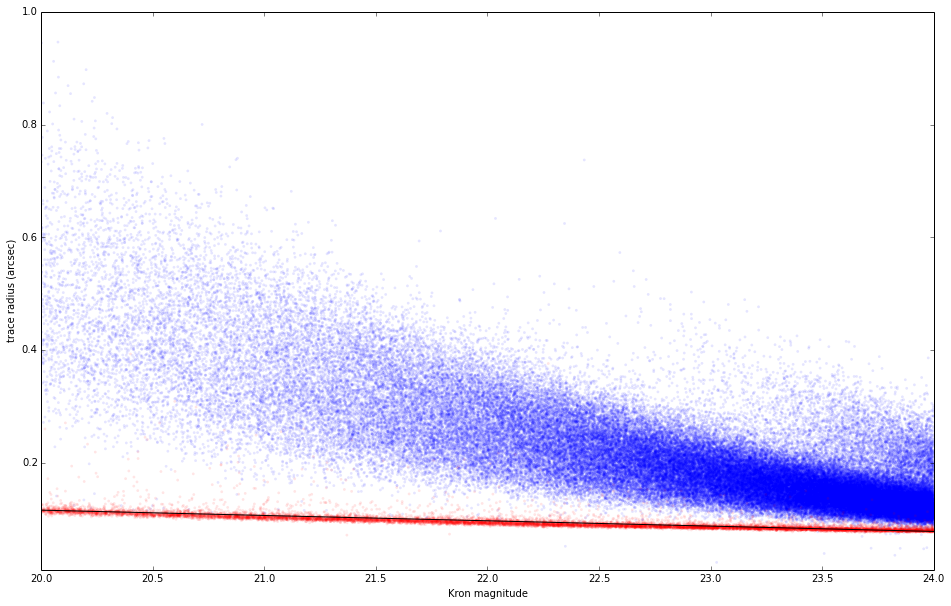

In [37]:
def fitStarPoly(xMin=20.0, xMax=24.0, yMin=0.01, yMax=1.0):
    x = cat["MAG_AUTO"]
    y = rDet
    good = numpy.logical_and.reduce([x >= xMin, x <= xMax, y >= yMin, y <= yMax])
    galaxies = numpy.logical_and.reduce([good, cat["MU_CLASS"] == 1])
    stars = numpy.logical_and.reduce([good, cat["MU_CLASS"] == 2])
    plt.scatter(x[galaxies], y[galaxies], c='b', s=8, alpha=0.1, linewidth=0)
    plt.scatter(x[stars], y[stars], c='r', s=8, alpha=0.1, linewidth=0)
    poly = numpy.poly1d(numpy.polyfit(x[stars], y[stars], 1))
    xr = numpy.linspace(xMin, xMax, 100)
    plt.plot(xr, poly(xr), 'k-')
    #plt.hexbin(x[mask], y[mask], yscale='log', marginals=True)
    plt.xlim(xMin, xMax)
    plt.ylim(yMin, yMax)
    plt.ylabel("trace radius (arcsec)")
    plt.xlabel("Kron magnitude")
    return poly
poly = fitStarPoly()

In [38]:
def correctEllipses(catalog, star_poly):
    """Return trace radius and axis ratio after attempting to deconvolve Kron radii"""
    x = catalog["MAG_AUTO"]
    a = catalog["A_WORLD"]*3600
    b = catalog["b_WORLD"]*3600
    p = star_poly(x)
    ac2 = numpy.maximum(a*a - p*p, 0.0)
    bc2 = numpy.maximum(b*b - p*p, 0.0)
    q = (bc2/ac2)**0.5
    q[numpy.isnan(q)] = 1.0
    return (0.5*(ac2 + bc2))**0.5, q

In [44]:
r, q = correctEllipses(cat, poly)
table = numpy.zeros(len(r), dtype=numpy.dtype([("mag", float), ("lnR", float), ("eta", float)]))
table["mag"] = cat["MAG_AUTO"]
table["lnR"] = numpy.log(r)
table["eta"] = -numpy.log(q)
numpy.save("cosmos.npy", table[cat["MU_CLASS"] == 1])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


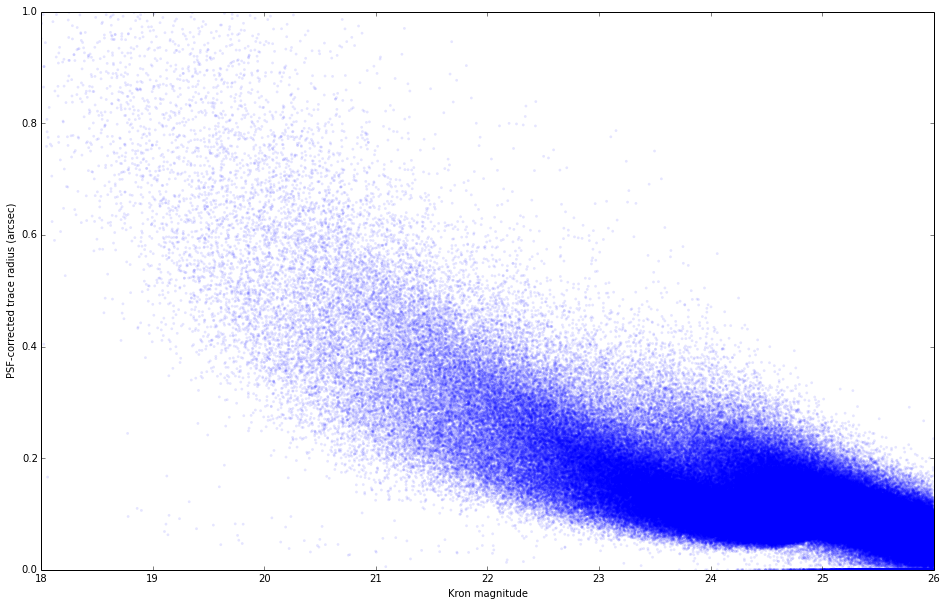

In [28]:
def plotSizeMag(magMin=18.0, magMax=26.0, rMin=0.0, rMax=1.0):
    mag = cat["MAG_AUTO"]
    r, q = correctEllipses(cat, poly)
    good = numpy.logical_and.reduce([mag >= magMin, mag <= magMax])
    galaxies = numpy.logical_and.reduce([good, cat["MU_CLASS"] == 1])
    stars = numpy.logical_and.reduce([good, cat["MU_CLASS"] == 2])
    plt.scatter(mag[galaxies], r[galaxies], c='b', s=8, alpha=0.1, linewidth=0)
    plt.xlim(magMin, magMax)
    plt.ylim(rMin, rMax)
    plt.ylabel("PSF-corrected trace radius (arcsec)")
    plt.xlabel("Kron magnitude")
plotSizeMag()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


-2.43307 0.38740153647
0.436126738787


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in less_equal


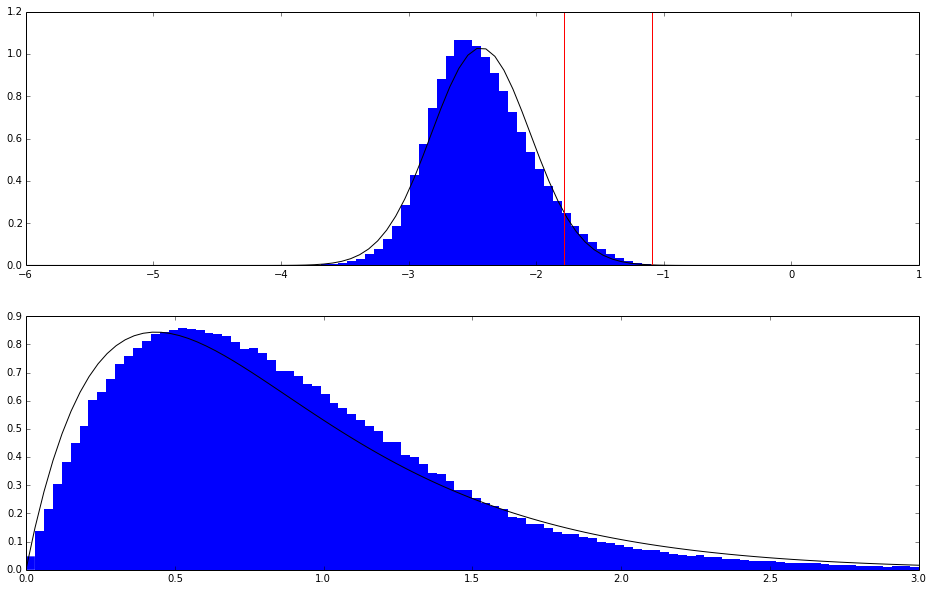

In [34]:
def plotParamHist(magMin=24.0, magMax=26.0, lnR_min=-6.0, lnR_max=1.0, etaMin=0.0, etaMax=3.0):
    mag = cat["MAG_AUTO"]
    rTr, q  = correctEllipses(cat, poly)
    good = numpy.logical_and.reduce([mag >= magMin, mag <= magMax,
                                     numpy.log(rTr) >= lnR_min, numpy.log(rTr) <= lnR_max, 
                                     cat["MU_CLASS"] == 1, q > 0.0])
    n = good.sum()
    lnR_x = numpy.linspace(lnR_min, lnR_max, 100)
    eta_x = numpy.linspace(etaMin, etaMax, 100)
    lnR = numpy.log(rTr[good])
    eta = -numpy.log(q[good])
    lnR_mu = numpy.mean(lnR)
    lnR_sigma = (numpy.sum((lnR - lnR_mu)**2)/(n - 1))**0.5
    eta_sigma = numpy.mean(eta)/2
    print lnR_mu, lnR_sigma
    print eta_sigma
    plt.subplot(2,1,1)
    plt.hist(lnR, bins=100, range=(lnR_min, lnR_max), normed=True, linewidth=0)
    plt.plot(lnR_x, numpy.exp(-0.5*(lnR_x-lnR_mu)**2/(lnR_sigma**2))/(lnR_sigma*(2*numpy.pi)**0.5), 'k-')
    plt.xlim(lnR_min, lnR_max)
    plt.axvline(numpy.log(0.168), color='r')
    plt.axvline(numpy.log(2*0.168), color='r')
    plt.subplot(2,1,2)
    plt.hist(eta, bins=100, linewidth=0, range=(etaMin, etaMax), normed=True)
    plt.plot(eta_x, numpy.exp(-(eta_x/eta_sigma))*(eta_x/eta_sigma**2), 'k-')
    
plotParamHist()

In [49]:
(cat["A_WORLD"]/cat["A_IMAGE"]).mean()*3600

0.030034739393158816

In [134]:
rTr, q  = correctEllipses(cat, poly)

509.536 509.536


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


In [132]:
q[cat["MU_CLASS"] == 1].min()

1.0

In [162]:
numpy.histogram?

In [2]:
import lsst.meas.multifit

In [17]:
ctrl = lsst.meas.multifit.SemiEmpiricalPriorControl()
p = lsst.meas.multifit.SemiEmpiricalPrior(ctrl)
eta1 = numpy.linspace(-ctrl.ellipticitySigma*4, ctrl.ellipticitySigma*4, 1000)
eta2 = eta1
lnR = numpy.linspace(ctrl.logRadiusMinOuter-0.1, ctrl.logRadiusMu+ctrl.logRadiusSigma*5, 1000)
#grid = numpy.zeros(eta1.shape + eta2.shape + lnR.shape, dtype=float)
def vectorize(prior, array, index, nonlinear, amplitudes=None):
    if amplitudes is None: amplitudes = numpy.array([1], dtype=float)
    result = numpy.zeros(len(array), dtype=float)
    deriv = numpy.zeros(len(array), dtype=float)
    for i in xrange(len(result)):
        base = nonlinear.copy()
        grad = numpy.zeros(4, dtype=float)
        hessian = numpy.zeros((4,4), dtype=float)
        base[index] = array[i]
        result[i] = prior.evaluate(base, amplitudes)
        prior.evaluateDerivatives(base, amplitudes, grad[:3], grad[3:],
                                  hessian[:3,:3], hessian[3:,3:], hessian[3:,1:])
        deriv[i] = grad[index]
    return result, deriv

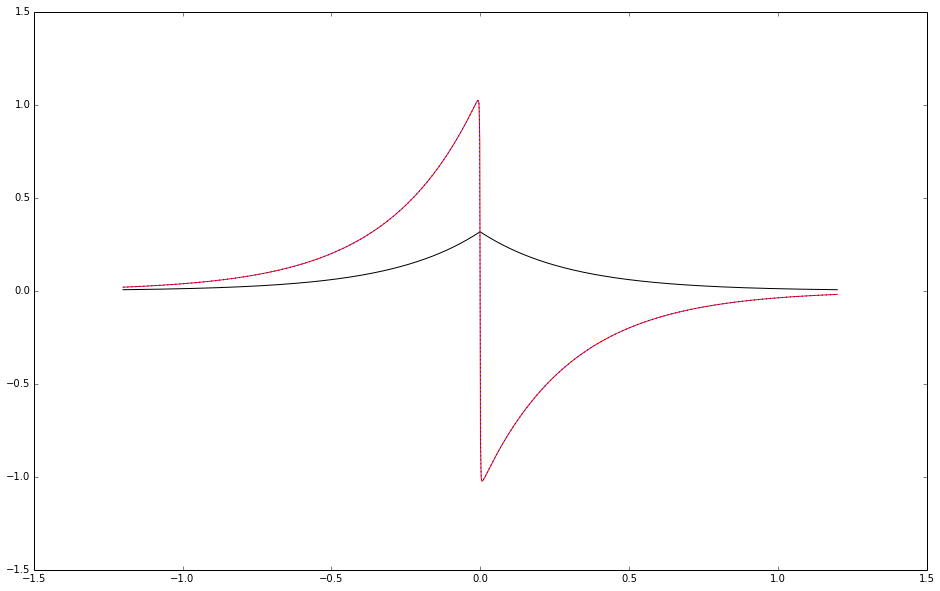

In [20]:
v, d = vectorize(p, eta1, 0, numpy.array([0.0, 0.0, ctrl.logRadiusMu]))
plt.plot(eta1, v, 'k')
plt.plot(eta1, d, 'r')
plt.plot(0.5*(eta1[1:] + eta1[:-1]), (v[1:]-v[:-1])/(eta1[1:]-eta1[:-1]), 'b:')
